long term memory를 잘 처리하기 위한 시도 중 하나

# 9.2.1. Gated Memory cell

LSTM은 hidden state와 같은 shape의 memory cell을 도입하였다. 두개의 gate가 있는데 하나는 입력단에 있고 하나는 출력단에 있다. 각각 input gate, output gate라 한다.

cell의 내용을 초기화해줄 메커니즘도 필요한데 이는 forget gate라 한다.


- 무엇을 기억하고, 무엇을 무시할지 학습하는 것이 해당 gate들의 존재 이유이다.

## 9.2.1.1. Input Gate, Forget Gate, Output Gate

현재 step (t)에서의 입력과 이전 step (t-1)에서의 은닉값이 입력으로 들어간다. 

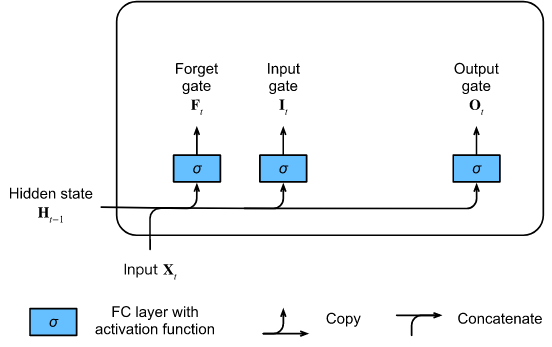

\begin{split}\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}\end{split}

## 9.2.1.2. Candidate Memory Cell

tanh 함수를 사용하기에 해당 cell은 (-1, 1)의 출력 범위를 갖는다.

\begin{split}\begin{aligned}
\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),
\end{aligned}\end{split}

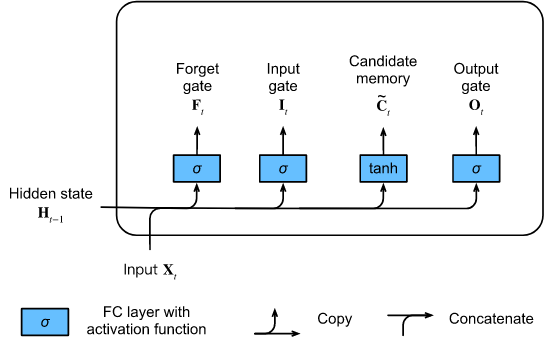

## 9.2.1.3. Memory Cell

\begin{split}\begin{aligned}
\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.
\end{aligned}\end{split}

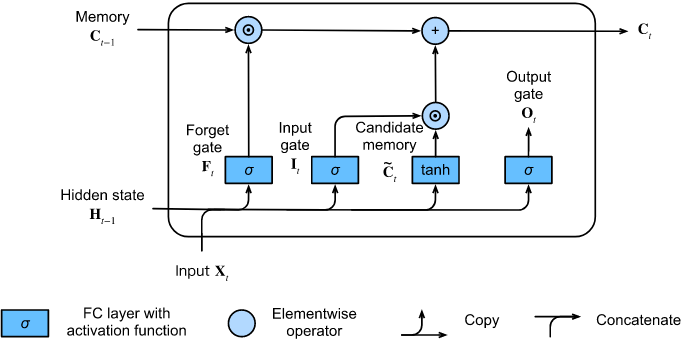

## 9.2.1.4. Hidden State

\begin{split}\begin{aligned}
\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).
\end{aligned}\end{split}

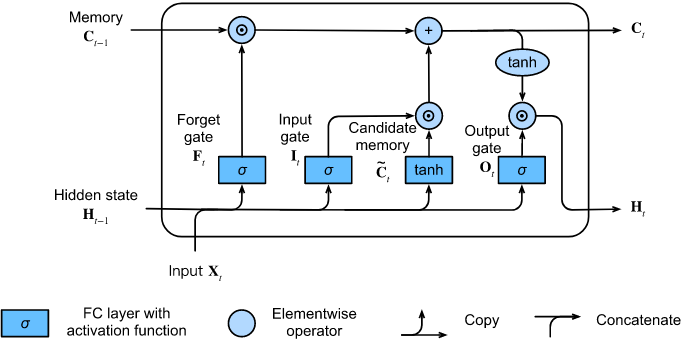

### Input Gate, Forget Gate, Output Gate
\begin{split}\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}\end{split}


### Candidate Memory Cell
\begin{split}\begin{aligned}
\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),
\end{aligned}\end{split}


### Memory Cell
\begin{split}\begin{aligned}
\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.
\end{aligned}\end{split}

### Hidden State
\begin{split}\begin{aligned}
\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).
\end{aligned}\end{split}

# 9.2.2. Implementation from Scratch

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 9.2.2.1. Initializing Model Parameters

weights를 Gaussian 분포로 초기화.. 

N(0, 0.01)로 초기화하면 됨

In [11]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    def three():
        return (normal((num_inputs, num_hiddens)),
               normal((num_hiddens, num_hiddens)),
               torch.zeros(num_hiddens, device=device))
    W_xi, W_hi, b_i = three()
    W_xf, W_hf, b_f = three()
    W_xo, W_ho, b_o = three()
    W_xc, W_hc, b_c = three()
    
    # Output params
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    # Attach Gradients
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## 9.2.2.2. Defining the Model

LSTM을 초기화할 때, hidden state는 (batch size, num of hidden units)의 사이즈를 갖는 '0' 값을 가져야 한다.

In [12]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
           torch.zeros((batch_size, num_hiddens), device=device))

In [13]:
def lstm(inputs, num_hiddens, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    
    for X in inputs:
        I = torch.sigmoid(X@W_xi + H@W_hi + b_i)
        F = torch.sigmoid(X@W_xf + H@W_hf + b_f)
        O = torch.sigmoid(X@W_xo + H@W_ho + b_o)
        
        C_tilda = torch.tanh(X@W_xc + H@W_hc + b_c)
        
        C = F*C + I*C
        
        H = O * torch.tanh(C)
        Y = (H@W_hq) + b_hq
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)
    

NameError: name 'state' is not defined

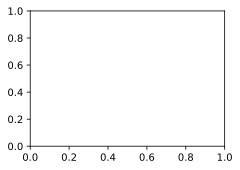

In [14]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 15230.3 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


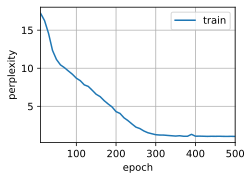

In [6]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)